## [0단계] 사용할 라이브러리와 패키지 불러오기 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## [1단계] 데이터 로드

In [8]:
df = pd.read_csv("../data/merged/traffic_weather_with_cluster.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["date"] = df["datetime"].dt.floor("D")
df["hour"] = df["datetime"].dt.hour

print(df.head())

# 한글 폰트
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

             datetime intersection  traffic_volume  is_offday  temp  \
0 2024-11-02 00:00:00         2공단3             341          1  15.2   
1 2024-11-02 01:00:00         2공단3             190          1  15.6   
2 2024-11-02 02:00:00         2공단3             207          1  14.1   
3 2024-11-02 03:00:00         2공단3             180          1  13.5   
4 2024-11-02 04:00:00         2공단3             230          1  13.2   

   precipitation  wind  cluster       date  hour  
0            0.0   1.1        0 2024-11-02     0  
1            0.0   1.4        0 2024-11-02     1  
2            0.0   0.7        0 2024-11-02     2  
3            0.0   0.5        0 2024-11-02     3  
4            0.0   0.0        0 2024-11-02     4  


## [2단계] 피크 시간대 산출

In [9]:
# 상시혼잡형 교차로 필터링 (cluster 1)
congested_df = df[df["cluster"] == 1].copy()
unique_intersections = congested_df["intersection"].unique()

print("\n✅ 상시혼잡형 교차로 개수:", len(unique_intersections))
print("교차로 샘플:", congested_df["intersection"].unique()[:5])

# 데이터 기반 피크 시간 자동 추출
peak_hours = (
    congested_df.groupby("hour")["traffic_volume"]
    .mean()
    .sort_values(ascending=False)
    .head(4)
    .index
    .tolist()
)

print("\n✅ 데이터 기반 피크 시간대 (Top 4):", peak_hours)

# 피크 시간 여부 변수 생성
congested_df["is_peak"] = congested_df["hour"].isin(peak_hours).astype(int)

print(congested_df[["hour", "is_peak"]].head())


✅ 상시혼잡형 교차로 개수: 31
교차로 샘플: ['고재4' '구성3' '굴울(변전소)4' '남부5' '도로원점3']

✅ 데이터 기반 피크 시간대 (Top 4): [17, 16, 15, 18]
    hour  is_peak
48     0        0
49     1        0
50     2        0
51     3        0
52     4        0


## [3단계] 신호 주기 조정 정책 시나리오 적용 (5%, 10%, 15%)

In [10]:
policy_rates = [0.05, 0.10, 0.15]

for rate in policy_rates:
    congested_df[f"traffic_after_{int(rate*100)}"] = congested_df["traffic_volume"]
    congested_df.loc[
        congested_df["is_peak"] == 1,
        f"traffic_after_{int(rate*100)}"
    ] = congested_df["traffic_volume"] * (1 - rate)

# 정책 적용 전/후 평균 교통량 비교
policy_result = congested_df.groupby("intersection").agg(
    before=("traffic_volume", "mean"),
    after_5=("traffic_after_5", "mean"),
    after_10=("traffic_after_10", "mean"),
    after_15=("traffic_after_15", "mean"),
)

# 개선률(%) 계산
policy_result["improve_5(%)"]  = (policy_result["before"] - policy_result["after_5"])  / policy_result["before"] * 100
policy_result["improve_10(%)"] = (policy_result["before"] - policy_result["after_10"]) / policy_result["before"] * 100
policy_result["improve_15(%)"] = (policy_result["before"] - policy_result["after_15"]) / policy_result["before"] * 100

print(policy_result.head())

# 신호 조정 효과 Top 10 교차로 (10% 기준)
top10 = policy_result.sort_values("improve_10(%)", ascending=False).head(10)

print("\n📌 ✅ 신호 조정 효과 TOP 10 교차로 (10% 기준)")
print(top10)

                   before      after_5     after_10     after_15  \
intersection                                                       
고재4           2305.680708  2274.812175  2243.943642  2213.075108   
구성3           2676.586073  2639.839446  2603.092820  2566.346193   
굴울(변전소)4      1981.282420  1954.503864  1927.725308  1900.946752   
남부5           2025.839155  1997.180953  1968.522751  1939.864549   
도로원점3         2436.702283  2403.993636  2371.284989  2338.576341   

              improve_5(%)  improve_10(%)  improve_15(%)  
intersection                                              
고재4               1.338803       2.677607       4.016410  
구성3               1.372892       2.745783       4.118675  
굴울(변전소)4          1.351577       2.703154       4.054731  
남부5               1.414634       2.829267       4.243901  
도로원점3             1.342333       2.684665       4.026998  

📌 ✅ 신호 조정 효과 TOP 10 교차로 (10% 기준)
                   before      after_5     after_10     after_15  \
intersec

/var/folders/0d/m7j0wkqs1jqfzpwn9wg_s_280000gn/T/ipykernel_66528/3791133341.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3750.6  3780.05 3862.7  ... 4332.   4346.25 3826.6 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  congested_df.loc[
/var/folders/0d/m7j0wkqs1jqfzpwn9wg_s_280000gn/T/ipykernel_66528/3791133341.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3553.2 3581.1 3659.4 ... 4104.  4117.5 3625.2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  congested_df.loc[
/var/folders/0d/m7j0wkqs1jqfzpwn9wg_s_280000gn/T/ipykernel_66528/3791133341.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3355.8  3382.15 3456.1  ... 3876.   3888.75 3423

## [4단계] 시각화

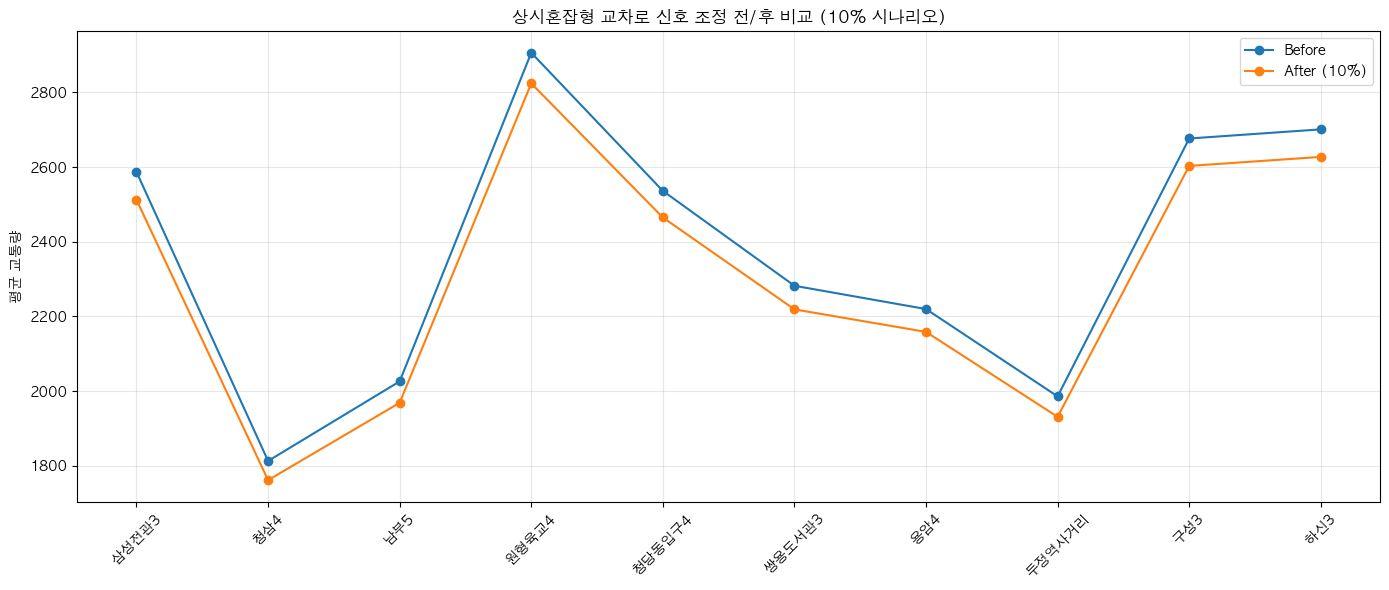


✅ 정책 실험 결과 CSV 저장 완료 → results/policy_simulation_result.csv


In [11]:
plt.figure(figsize=(14,6))

plt.plot(top10.index, top10["before"], label="Before", marker="o")
plt.plot(top10.index, top10["after_10"], label="After (10%)", marker="o")

plt.xticks(rotation=45)
plt.ylabel("평균 교통량")
plt.title("상시혼잡형 교차로 신호 조정 전/후 비교 (10% 시나리오)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 정책 실험 결과 저장
policy_result.to_csv("../results/policy_simulation_result.csv", encoding="utf-8-sig")

print("\n✅ 정책 실험 결과 CSV 저장 완료 → results/policy_simulation_result.csv")
